In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "gemini.json"

api_key = os.environ.get("OPENAI_API_KEY")
if api_key is None:
    raise RuntimeError("Please set the OPENAI_API_KEY ")

In [2]:
from scirag import SingleRAGEvaluationSystem

/Users/apple/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/pybtex/plugin/__init__.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Plot

In [ ]:
# Perplexity Assistant 11.43
# VertexAI Assistant 78.10
#HybridGemGem Assistant 80
# Gemini Assistant 18.10
# PaperQA2 65.05
# Modified PaperQA2 65.71
#OpenAI Assistant 80.00
#OpenAIPDF Assistant 84.76
# HybridOAIGem Assistant 83.65



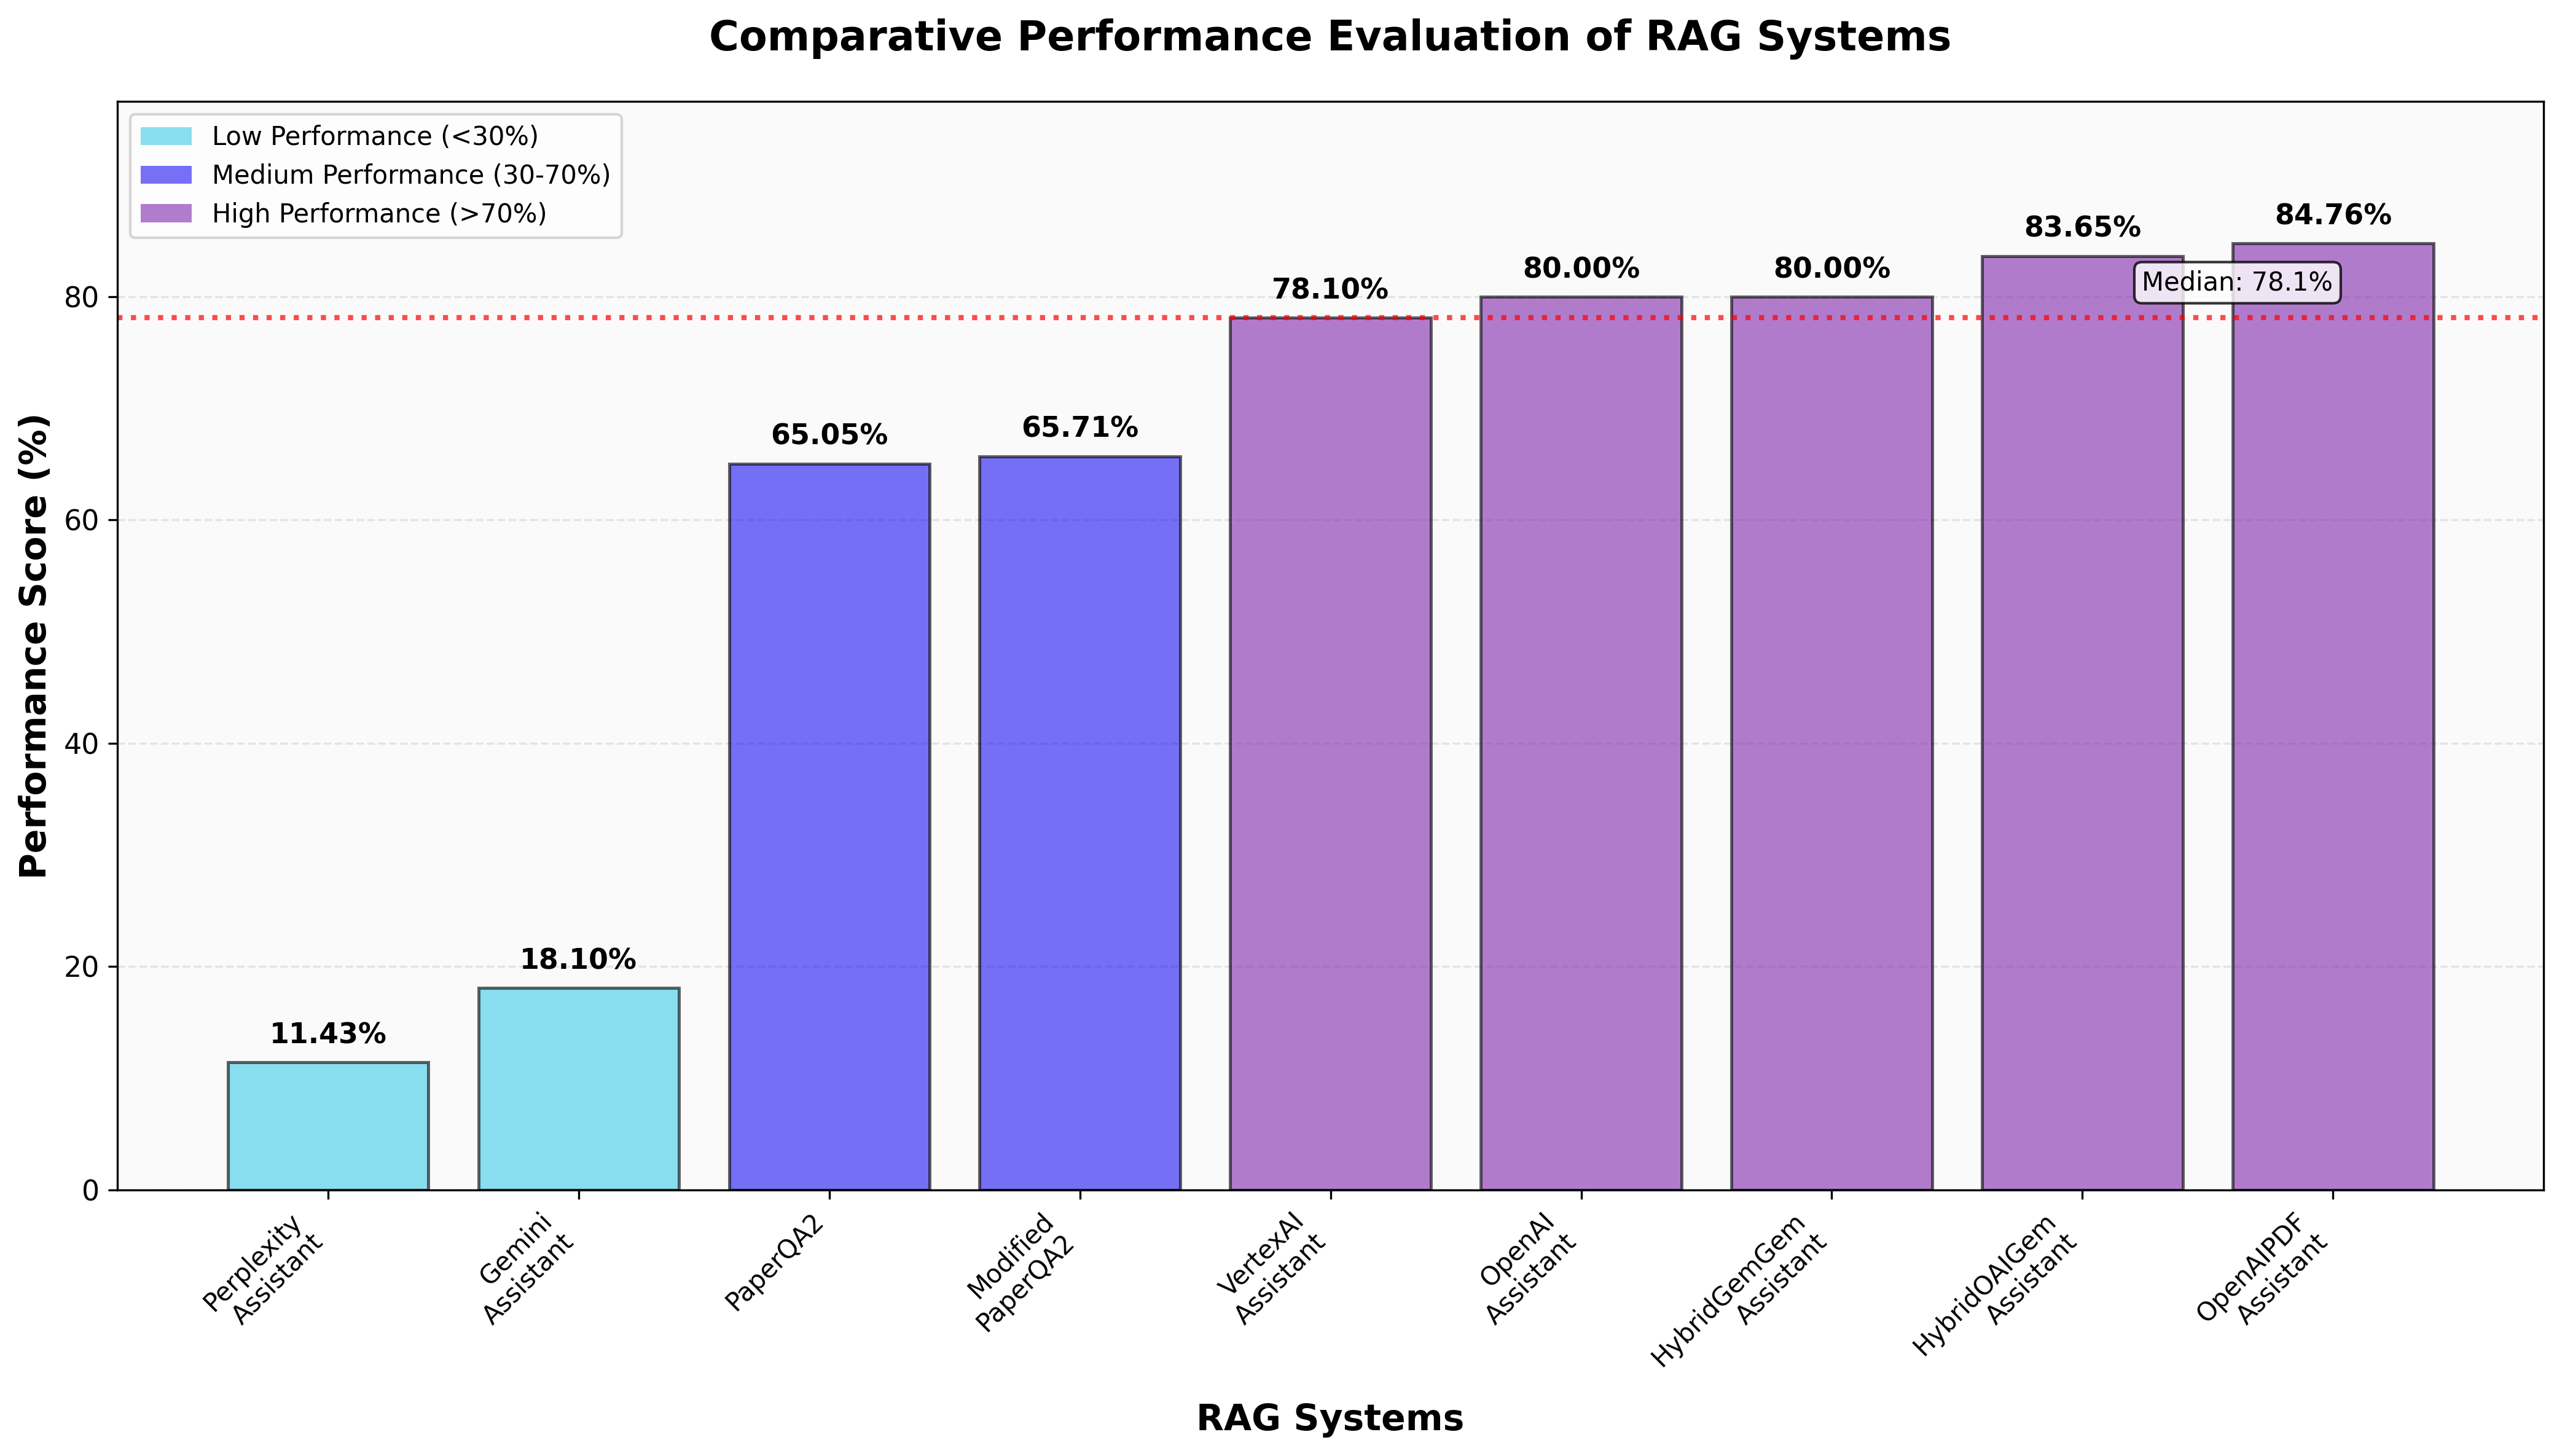

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style for scientific papers
plt.style.use('default')
sns.set_palette("husl")

# Data
systems = [
    'Perplexity\nAssistant',
    'Gemini\nAssistant', 
    'PaperQA2',
    'Modified\nPaperQA2',
    'VertexAI\nAssistant',
    'OpenAI\nAssistant',
    'HybridGemGem\nAssistant',
    'HybridOAIGem\nAssistant',
    'OpenAIPDF\nAssistant'
]


scores = [11.43, 18.10, 65.05, 65.71, 78.10, 80.00, 80.00, 83.65, 84.76]

# Create figure with high DPI for paper quality
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

# Create color map based on performance tiers
colors = []
for score in scores:
    if score < 30:
        colors.append("#3CCBE7")  # Red for low performance
    elif score < 70:
        colors.append("#1D12F3")  # Orange for medium performance
    else:
        colors.append("#8127AE")  # Green for high performance

# Create the bar plot
bars = ax.bar(systems, scores, color=colors, alpha=0.6, edgecolor='black', linewidth=1.2)

# Add value annotations on top of bars
for i, (bar, score) in enumerate(zip(bars, scores)):
    height = bar.get_height()
    ax.annotate(f'{score:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # 5 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Customize the plot
ax.set_ylabel('Performance Score (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('RAG Systems', fontsize=14, fontweight='bold')
ax.set_title('Comparative Performance Evaluation of RAG Systems', 
             fontsize=16, fontweight='bold', pad=20)

# Set y-axis limits with some padding
ax.set_ylim(0, max(scores) * 1.15)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=11)

# Add performance tier legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#3CCBE7", alpha=0.6, label='Low Performance (<30%)'),
    Patch(facecolor="#1D12F3", alpha=0.6, label='Medium Performance (30-70%)'),
    Patch(facecolor="#8127AE", alpha=0.6, label='High Performance (>70%)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Add a horizontal line for the median performance
median_score = np.median(scores)
ax.axhline(y=median_score, color='red', linestyle=':', alpha=0.7, linewidth=2)
ax.text(len(systems)-1, median_score+2, f'Median: {median_score:.1f}%', 
        ha='right', va='bottom', fontsize=10, 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add subtle background
ax.set_facecolor('#FAFAFA')

# Show the plot
plt.show()



# Perplexity Result

In [22]:
perplexity=pd.read_pickle("results/perplexity_results_final.pkl")


In [23]:
rag_evaluator = SingleRAGEvaluationSystem(
        evaluator_model="o3-mini"
    )

In [24]:

perplexity_evaluated = rag_evaluator.evaluate_single_dataframe(
    df=perplexity,
    system_name="Perplexity"
)


EVALUATING: Perplexity
All required columns found
Available columns: ['question_id', 'question', 'response', 'answer', 'sources', 'ideal_solution', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
The Planck 2018 analysis tested the standard recombination history through multiple methodological and observational approaches, as detailed in the referenced works:

1. **Recombination Code Validation**:
   - The analysis employed advanced recombination codes like **CosmoRec** and **HyRec** to compute the ionization history [1][5]. These codes solve the non-equilibrium thermodynamics of hydrogen and helium recombination with sub-percent precision, ensuring theoretical consistency with the standa

# Vertex RAG

In [26]:
Vetex_RAG=pd.read_pickle("results/vertexai_rag_results_final.pkl")

In [27]:

Vetex_RAG_evaluated = rag_evaluator.evaluate_single_dataframe(
    df=Vetex_RAG,
    system_name="Gemini_embedding"
)


EVALUATING: Gemini_embedding
All required columns found
Available columns: ['question_id', 'question', 'response', 'answer', 'sources', 'ideal_solution', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
The Planck 2018 analysis tested the standard recombination history using a semi-blind eigen-analysis, also known as a principal-component analysis. This method expanded deviations of the free-electron fraction from the standard recombination history into 80 redshift bands, spanning from before helium recombination to after hydrogen recombination.

IDEAL ANSWER:
semi-blind eigen-analysis (often referred to as a principal-component analysis)


Evaluate based on:
Accuracy (0-100): How factuall

# Evaluate Gemini Embedding

In [18]:
import pandas as pd

In [4]:
gemini_embedding_df=pd.read_pickle("results/gemini_embedding_results.pkl")

In [5]:
rag_evaluator = SingleRAGEvaluationSystem(
        evaluator_model="o3-mini"
    )

In [6]:

gemini_embedding_evaluated = rag_evaluator.evaluate_single_dataframe(
    df=gemini_embedding_df,
    system_name="Gemini_embedding"
)


EVALUATING: Gemini_embedding
All required columns found
Available columns: ['question_id', 'question', 'ideal_solution', 'response', 'answer', 'sources', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
The standard recombination history is tested in the Planck 2018 analysis using a semi-blind eigen-analysis of deviations in the free-electron fraction, $x_{\mathrm{e}}(z)$, from the standard model. Perturbations in $x_{\mathrm{e}}(z)$ are expanded into eigenmodes (eXeMs), and their amplitudes are determined through MCMC sampling, showing consistency with no deviation from standard recombination.

IDEAL ANSWER:
semi-blind eigen-analysis (often referred to as a principal-component analysis)



In [7]:
gemini_embedding_evaluated

,question_id,question,ideal_solution,response,answer,sources,processing_time,success,error,embedding_system,eval_accuracy_score,eval_rationale,eval_successful,eval_error,eval_processing_time
0,1,How is the standard recombination history test...,semi-blind eigen-analysis (often referred to a...,**Answer**:\n\nThe standard recombination hist...,The standard recombination history is tested i...,"1807.06209v4.md, Section 7.7, Page 29, 1807.06...",6.377757,True,None,Gemini,100,The generated answer correctly identifies that...,True,None,2.468975
1,2,Which corrections in polarization spectra were...,Beam leakage correction; effective polarizatio...,"**Answer**:\n\nIn the 2018 Planck analysis, co...","In the 2018 Planck analysis, corrections appli...",1807.06209v4.md,5.089953,True,None,Gemini,0,The generated answer correctly mentions the be...,True,None,4.234283
2,3,What multipole cuts were applied in the Camspe...,"lmin=500, lmax=2500","**Answer**:\n\nFor the Planck 2018 analysis, t...","For the Planck 2018 analysis, the Camspec temp...",1807.06209v4.md,3.338507,True,None,Gemini,100,The generated answer correctly identifies the ...,True,None,3.105753
3,4,What is the effective sky-fraction of the apod...,47.70%,"**Answer**:\n\nFor the Planck 2018 analysis, t...","For the Planck 2018 analysis, the default apod...",1807.06209v4.md,3.815803,True,None,Gemini,100,The response accurately states the effective s...,True,None,3.074765
4,5,How large is the impact of beam window functio...,approximately 0.1% at l=2000,**Answer**:\n\nThe impact of beam window funct...,The impact of beam window functions on the 201...,1807.06209v4.md,3.641038,True,None,Gemini,100,The generated answer accurately states that th...,True,None,2.324985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,101,What would be the signs of dark matter annihil...,Damping of high-l power in both temperature an...,**Answer**:\n\nDark matter annihilation into S...,Dark matter annihilation into Standard Model p...,"2503.14454v1.md, Section 6.4.2",3.279053,True,None,Gemini,100,The generated answer matches the core factual ...,True,None,2.301998
101,102,"In the ACT DR6 paper, why is the constraint fo...",Bayesian constraints on the IDR-IDM model caus...,**Answer**:\n\nThe upper limit on N_idr for th...,The upper limit on N_idr for the IDR-IDM model...,"2503.14454v1.md, Section 6.5.2, Figure 35 capt...",4.467764,True,None,Gemini,0,The generated answer states that small shifts ...,True,None,3.893513
102,103,Why does including f\sigma_8 measurements into...,The f\sigma_8 dataset contains two low-z point...,**Answer**:\n\nIncluding fσ8 measurements dram...,Including fσ8 measurements dramatically increa...,"2503.14454v1.md, Context 2, Figure 39, 2503.14...",4.156666,True,None,Gemini,100,The generated answer correctly identifies that...,True,None,3.669901
103,104,Do the extensions to \lambdaCDM considered in ...,No. The range of H_0 given by the models studi...,"**Answer**:\n\nNo, the extensions to the Lambd...","No, the extensions to the LambdaCDM model cons...","2503.14454v1.md, Section 8.2, Cosmological con...",6.575425,True,None,Gemini,100,The generated answer correctly states that the...,True,None,2.801096


# gemini_no_rag

In [8]:
gemini_no_rag=pd.read_pickle("results/gemini_norag_results.pkl")

In [9]:

gemini_no_rag_eval = rag_evaluator.evaluate_single_dataframe(
    df=gemini_no_rag,
    system_name="Gemini_no_rag"
)


EVALUATING: Gemini_no_rag
All required columns found
Available columns: ['question_id', 'question', 'response', 'answer', 'sources', 'ideal_solution', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
The Planck 2018 analysis tests the standard recombination history by comparing observed Cosmic Microwave Background (CMB) anisotropies with theoretical predictions based on the standard cosmological model [1]. This allows for constraints on parameters that could modify the recombination process.

IDEAL ANSWER:
semi-blind eigen-analysis (often referred to as a principal-component analysis)


Evaluate based on:
Accuracy (0-100): How factually correct is the answer compared to the ideal?

Use the

# Evaluate Vanilla PaperQA

In [10]:
paperqa=pd.read_pickle("results/paperqa2_valina_gpt4.1_results.pkl")
paperqa_eval = rag_evaluator.evaluate_single_dataframe(
    df=paperqa,
    system_name="paperqa_modified_gpt4.1"
)


EVALUATING: paperqa_modified_gpt4.1
All required columns found
Available columns: ['question_id', 'question', 'response', 'answer', 'sources', 'ideal_solution', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
The Planck 2018 analysis tests the standard recombination history by comparing precise measurements of the CMB temperature, polarization, and lensing power spectra to theoretical predictions, and by performing a principal-component (eigenmode) analysis of perturbations to the free-electron fraction, $x_e(z)$; all results show no significant deviations from the standard recombination scenario and confirm the robustness of cosmological parameter estimates .

IDEAL ANSWER:
semi-blind ei

# Eavaluate PaperQA

In [11]:
paperqa_modified=pd.read_pickle("results/paperqa2_gpt4.1_results.pkl")
paperqa_modified_eval = rag_evaluator.evaluate_single_dataframe(
    df=paperqa_modified,
    system_name="paperqa_modified_gpt4.1"
)


EVALUATING: paperqa_modified_gpt4.1
All required columns found
Available columns: ['question_id', 'question', 'response', 'answer', 'sources', 'ideal_solution', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
The Planck 2018 analysis tests the standard recombination history by performing a principal-component (eigenmode) analysis of deviations in the free electron fraction, $x_e(z)$, fitting the amplitudes of these modes to CMB temperature, polarization, lensing, and BAO data; the results show no significant deviations from the standard recombination scenario, confirming its robustness with current data . The analysis also constrains possible non-standard effects, such as energy injection

ai_judge (to user):

***** Suggested tool call (call_6yrHLcqS2vK5w7VZPpc8RZkI): evaluate_response *****
Arguments: 
{"accuracy_score": 100, "rationale": "The generated answer correctly mentions that the Planck 2018 analysis uses a principal-component (eigenmode) analysis (which is equivalent to the semi-blind eigen-analysis mentioned in the ideal answer) to test for deviations in the recombination history. The extra details provided (fitting amplitudes to various datasets and constraining non-standard effects) do not contradict the ideal answer and are additional context. Thus, the core scientific concepts are correctly captured."}
**********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> TERMINATING RUN (9131ce40-d0b1-4ef1-a535-5ce355f417bb): Maximum turns (1) reached
Accuracy:100
  Time: 3.94s

Evaluating 2/105 - Question ID: 2
user (to ai_judge):


Please evaluate thi

# OpenAI_Vector_Store_no_pdf

In [12]:
openai_vector_no_pdf=pd.read_pickle("results/openai_vector_store_results.pkl")

In [13]:
openai_vector_no_pdf_eval = rag_evaluator.evaluate_single_dataframe(
    df=openai_vector_no_pdf,
    system_name="OpenAI_Vector_Store_md"
)


EVALUATING: OpenAI_Vector_Store_md
All required columns found
Available columns: ['question_id', 'question', 'ideal_solution', 'response', 'answer', 'sources', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
The standard recombination history in the Planck 2018 analysis is tested using a semi-blind principal-component (eigenmode) analysis of perturbations to the free-electron fraction, x_e(z), across redshifts relevant for recombination. The amplitudes of the first few eigenmodes (eXeMs) are constrained using Planck TT,TE,EE+lowE+lensing+BAO data, and all are found to be consistent with zero, indicating no significant deviation from the standard recombination scenario within the sensitivi

# OpenAI_Vector_Store_pdf


In [14]:
openai_vector_df=pd.read_pickle("results/openai_pdf_vector_store_results.pkl")

In [15]:
openai_vector_df_eval = rag_evaluator.evaluate_single_dataframe(
    df=openai_vector_df,
    system_name="OpenAI_Vector_Store"
)


EVALUATING: OpenAI_Vector_Store
All required columns found
Available columns: ['question_id', 'question', 'ideal_solution', 'response', 'answer', 'sources', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
In the Planck 2018 analysis, the standard recombination history is tested using a semi-blind principal-component (eigenmode) analysis of deviations in the free-electron fraction, xe(z), from the standard recombination scenario. This approach expands perturbations in xe(z) across 80 redshift bands, constructs eigenmodes (eXeMs), and fits their amplitudes to the data; the results show no significant evidence for deviations from the standard recombination history, with all mode amplitudes c

# OpenAi Embedding

In [16]:
openai_embedding=pd.read_pickle("results/openai_embedding_results_final.pkl")

In [17]:

gemini_no_openai_embedding_eval = rag_evaluator.evaluate_single_dataframe(
    df=openai_embedding,
    system_name="OpenAI_embedding"
)


EVALUATING: OpenAI_embedding
All required columns found
Available columns: ['question_id', 'question', 'response', 'ideal_solution', 'answer', 'sources', 'processing_time', 'success', 'error', 'embedding_system']
Filtering by success column: 105 successful out of 105 total

Evaluating 1/105 - Question ID: 1
user (to ai_judge):


Please evaluate this system's response against the ideal answer:

QUESTION: How is the standard recombination history tested in the Planck 2018 analysis?

GENERATED ANSWER:
The Planck 2018 analysis tests the standard recombination history by incorporating subtle atomic physics and radiative-transfer effects using advanced codes like CosmoRec and HyRec. It also performs a semi-blind eigen-analysis of deviations in the free-electron fraction from the standard history and uses non-parametric reconstructions, such as the ModRec model, to parametrize and test for departures in the ionization fraction.

IDEAL ANSWER:
semi-blind eigen-analysis (often referred to as a